<a href="https://colab.research.google.com/github/dearmahmud/MedVisionPipeline/blob/main/notebooks/Colab_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Location Check
import os, sys, subprocess, pathlib

# Detect if we're in Colab
IN_COLAB = "COLAB_GPU" in os.environ or "COLAB_RELEASE_TAG" in os.environ

if IN_COLAB:
    # Work in /content
    os.chdir("/content")
    REPO_URL = "https://github.com/dearmahmud/MedVisionPipeline.git"
    REPO_DIR = "MedVisionPipeline"

    # Clone if the folder doesn't exist; else just cd into it
    if not pathlib.Path(REPO_DIR).exists():
        print("Cloning repo...")
        subprocess.run(["git", "clone", REPO_URL], check=True)
    os.chdir(REPO_DIR)

# Ensure repo root on sys.path
ROOT = os.getcwd()
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

print("CWD:", ROOT)
print("Repo contents:", os.listdir(ROOT))

Cloning repo...
CWD: /content/MedVisionPipeline
Repo contents: ['models', '.git', 'README.txt', 'task1_classification', 'data', 'task3_retrieval', 'README.md', 'requirements.txt', 'reports', '.gitignore', 'task2_results.csv', 'config', 'notebooks', 'task2_report_generation', '__init__.py', 'outputs', 'X_ray.png', 'failure_cases']


In [ ]:
# Install dependencies from requirements.txt (quiet)
!pip -q install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 10.7 MB/s eta 0:00:00


In [ ]:
# Safety Check | Create standard output dirs if not present
import os
os.makedirs("models", exist_ok=True)
os.makedirs("outputs", exist_ok=True)
os.makedirs("reports", exist_ok=True)

print("Dirs OK: models/, outputs/, reports/")

Dirs OK: models/, outputs/, reports/


### Task 1: Train + Evaluate + Report

In [ ]:
!python -m task1_classification.train --epochs 10 --lr 1e-4 --batch_size 128 --save_path models/resnet_best.pth
!python -m task1_classification.evaluate --model_path models/resnet_best.pth
!python -m reports.make_task1_report

100% 4.17M/4.17M [00:01<00:00, 3.50MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100% 44.7M/44.7M [00:00<00:00, 183MB/s]
100% 37/37 [00:04<00:00,  7.95it/s]
Epoch [1/10] Train Loss: 0.3324 | Val Loss: 0.4983 | Val Acc: 0.8721
✅ Best model saved.
100% 37/37 [00:02<00:00, 13.45it/s]
Epoch [2/10] Train Loss: 0.1954 | Val Loss: 0.1932 | Val Acc: 0.9332
✅ Best model saved.
100% 37/37 [00:02<00:00, 13.46it/s]
Epoch [3/10] Train Loss: 0.1707 | Val Loss: 0.1825 | Val Acc: 0.9275
✅ Best model saved.
100% 37/37 [00:03<00:00, 10.19it/s]
Epoch [4/10] Train Loss: 0.1403 | Val Loss: 0.1744 | Val Acc: 0.9427
✅ Best model saved.
100% 37/37 [00:02<00:00, 12.79it/s]
Epoch [5/10] Train Loss: 0.1430 | Val Loss: 0.1780 | Val Acc: 0.9485
100% 37/37 [00:02<00:00, 13.34it/s]
Epoch [6/10] Train Loss: 0.1240 | Val Loss: 0.1498 | Val Acc: 0.9504
✅ Best model saved.
100% 37/37 [00:02<00:00, 13.49it/s]
Epoch [7/10] Train L

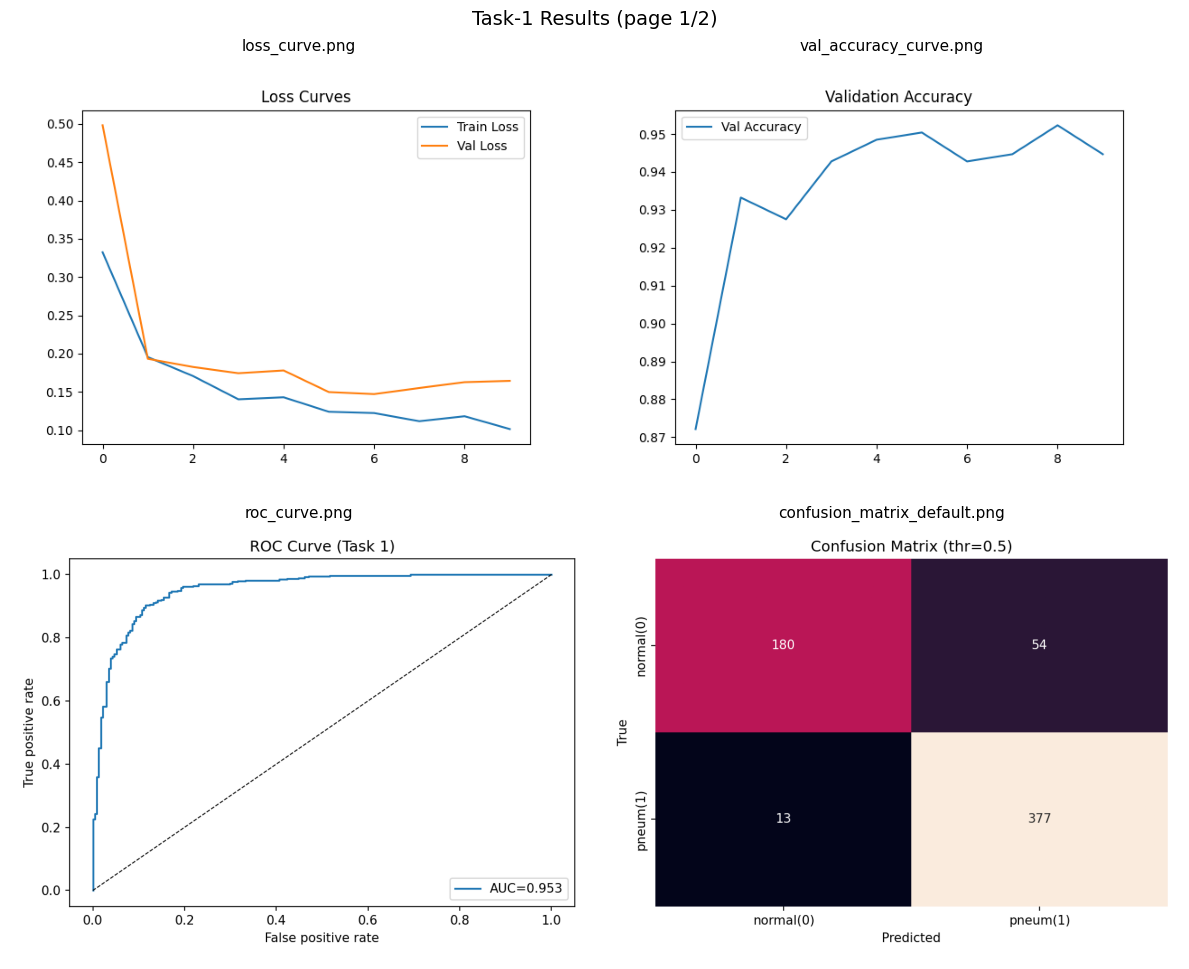

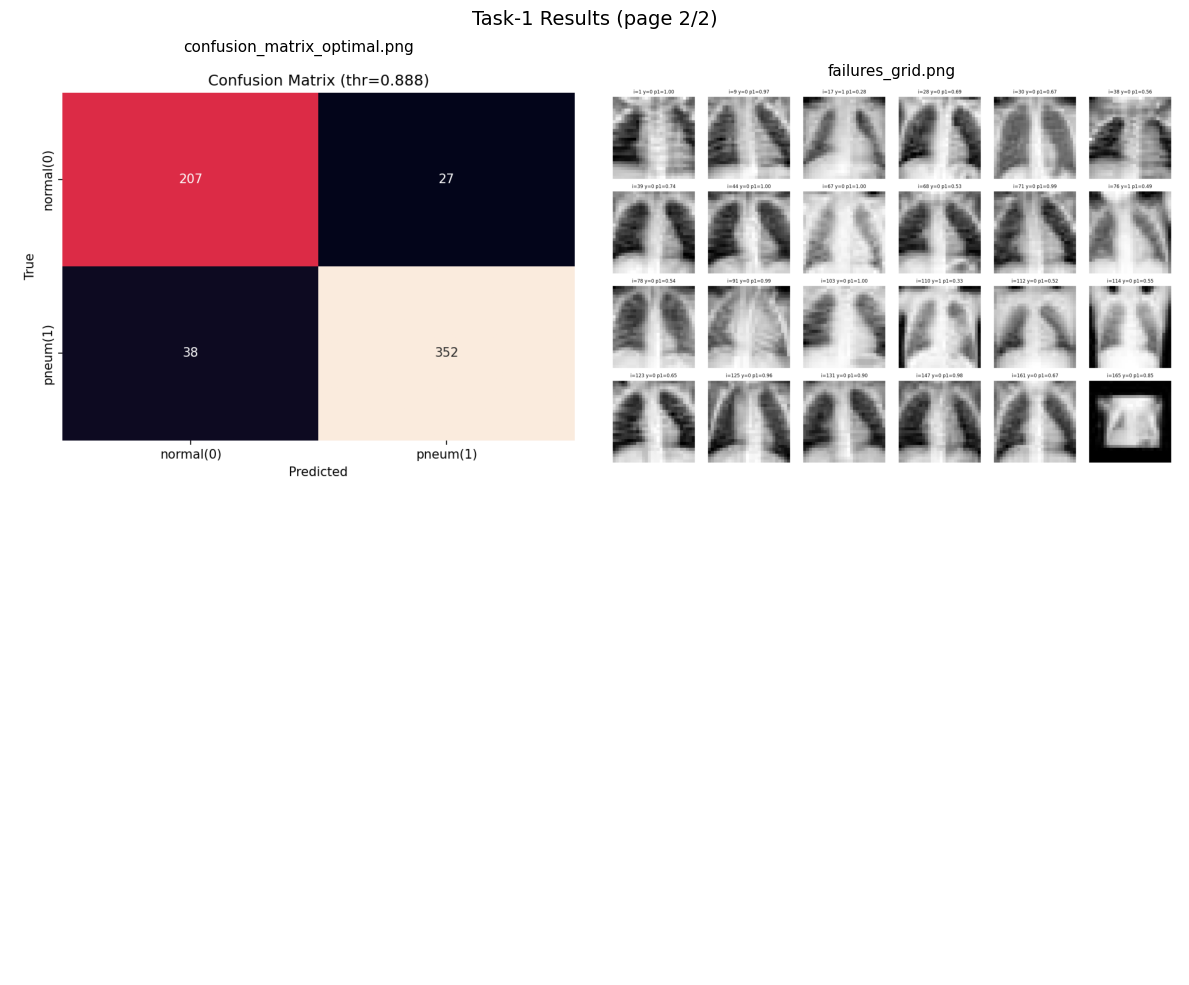

In [ ]:
import importlib, task1_classification.plot_grids as pg
importlib.reload(pg)  # IMPORTANT: picks up your latest file

task1_paths = [
    "outputs/loss_curve.png",
    "outputs/val_accuracy_curve.png",
    "outputs/roc_curve.png",
    "outputs/confusion_matrix_default.png",
    "outputs/confusion_matrix_optimal.png",
    "outputs/failures_grid.png",
]

pg.show_images_grid(paths=task1_paths, cols=2, rows=2, figsize=(12, 10), suptitle="Task-1 Results", paginate=True, tight=True)

### Task 2: VLM report generation (no hard-coded tokens)

In [ ]:
# --- Hugging Face auth (safe & optional) ---
import os, getpass

HF_TOKEN = os.environ.get("HF_TOKEN", "")

# Try Colab Secret (Runtime → Variables → add key 'HF_TOKEN') if available
try:
    from google.colab import userdata  # noqa: F401
    HF_TOKEN = HF_TOKEN or (userdata.get('HF_TOKEN') or "")
except Exception:
    pass

# As last resort, prompt (won't echo or save)
if not HF_TOKEN:
    print("No HF token detected. If you have one, paste it (or press Enter to skip Task 2):")
    HF_TOKEN = getpass.getpass("HF token: ").strip()

RUN_TASK2 = False
if HF_TOKEN:
    try:
        from huggingface_hub import login, whoami
        login(token=HF_TOKEN, add_to_git_credential=False)  # do NOT store globally
        who = whoami(token=HF_TOKEN)
        print("HF user:", who.get("name", "<unknown>"))
        os.environ["HF_TOKEN"] = HF_TOKEN  # downstream scripts can read it
        print("HuggingFace authentication successful.")
        RUN_TASK2 = True
    except Exception as e:
        print("HF login failed:", e)
        print("Proceeding without HF; Task 2 will be skipped or use fallback.")
else:
    print("Proceeding without HF; Task 2 will be skipped or use fallback.")

No HF token detected. If you have one, paste it (or press Enter to skip Task 2):
HF token: ··········
HF user: dearmahmud
HuggingFace authentication successful.


In [ ]:
# Task 2: Report Generation (with Hugging Face Token)
if RUN_TASK2:
    # Use your preferred model that needs HF auth (example)
    !python -m reports.make_task2_report --prefer_model "google/medgemma-4b-it"
else:
    print("Task 2 skipped (no HF token). If you have a token, set HF_TOKEN and re-run this cell.")

Device: cuda
Loading model: google/medgemma-4b-it
processor_config.json: 100% 70.0/70.0 [00:00<00:00, 282kB/s]
chat_template.jinja: 100% 1.53k/1.53k [00:00<00:00, 7.94MB/s]
preprocessor_config.json: 100% 570/570 [00:00<00:00, 2.63MB/s]
config.json: 100% 2.47k/2.47k [00:00<00:00, 12.6MB/s]
tokenizer_config.json: 100% 1.16M/1.16M [00:00<00:00, 4.88MB/s]
tokenizer.json: 100% 33.4M/33.4M [00:00<00:00, 39.7MB/s]
added_tokens.json: 100% 35.0/35.0 [00:00<00:00, 168kB/s]
special_tokens_map.json: 100% 662/662 [00:00<00:00, 3.39MB/s]
model.safetensors.index.json: 100% 90.6k/90.6k [00:00<00:00, 1.62MB/s]
Fetching 2 files: 100% 2/2 [01:59<00:00, 59.78s/it] 
Download complete: 100% 8.60G/8.60G [01:59<00:00, 71.9MB/s]
Loading weights: 100% 883/883 [00:34<00:00, 25.23it/s, Materializing param=model.vision_tower.vision_model.post_layernorm.weight] 
generation_config.json: 100% 156/156 [00:00<00:00, 766kB/s]
Some parameters are on the meta device because they were offloaded to the cpu.
Wrote reports/ta

### Task 3: Build index + Evaluate + Report

In [ ]:
!python -m task3_retrieval.build_index_medmnist
!python -m task3_retrieval.evaluate
!python -m reports.make_task3_report

=== Task 3: Building Retrieval Index from MedMNIST TEST ===
Loading CLIP model...
preprocessor_config.json: 100% 316/316 [00:00<00:00, 1.47MB/s]
config.json: 4.19kB [00:00, 2.23MB/s]
pytorch_model.bin: 100% 605M/605M [00:03<00:00, 185MB/s]
model.safetensors:   0% 0.00/605M [00:00<?, ?B/s]
Loading weights:   0% 0/398 [00:00<?, ?it/s]
Loading weights:   0% 1/398 [00:00<00:00, 9300.01it/s, Materializing param=logit_scale]
Loading weights:   0% 1/398 [00:00<00:00, 3927.25it/s, Materializing param=logit_scale]
Loading weights:   1% 2/398 [00:00<00:00, 2893.62it/s, Materializing param=text_model.embeddings.position_embedding.weight]
Loading weights:   1% 2/398 [00:00<00:00, 2386.52it/s, Materializing param=text_model.embeddings.position_embedding.weight]
Loading weights:   1% 3/398 [00:00<00:00, 1686.49it/s, Materializing param=text_model.embeddings.token_embedding.weight]   
Loading weights:   1% 3/398 [00:00<00:00, 1602.10it/s, Materializing param=text_model.embeddings.token_embedding.weig

In [ ]:
# Quick Retrieval
!python -m task3_retrieval.search --query_idx 0 --top_k 10
!python -m task3_retrieval.search --query_text "right lower lobe pneumonia" --top_k 10

Query by index = 0 -> medmnist:test_idx=0

Top-K results:
[1] score=0.9853  label=1  path=medmnist:test_idx=167
[2] score=0.9847  label=1  path=medmnist:test_idx=522
[3] score=0.9823  label=1  path=medmnist:test_idx=467
[4] score=0.9809  label=0  path=medmnist:test_idx=556
[5] score=0.9807  label=0  path=medmnist:test_idx=20
[6] score=0.9805  label=1  path=medmnist:test_idx=618
[7] score=0.9795  label=1  path=medmnist:test_idx=325
[8] score=0.9791  label=0  path=medmnist:test_idx=390
[9] score=0.9789  label=1  path=medmnist:test_idx=616
[10] score=0.9786  label=1  path=medmnist:test_idx=183
tokenizer_config.json: 100% 592/592 [00:00<00:00, 2.43MB/s]
vocab.json: 862kB [00:00, 7.12MB/s]
merges.txt: 525kB [00:00, 9.73MB/s]
tokenizer.json: 2.22MB [00:00, 14.1MB/s]
special_tokens_map.json: 100% 389/389 [00:00<00:00, 1.98MB/s]
Loading weights: 100% 398/398 [00:00<00:00, 811.09it/s, Materializing param=visual_projection.weight]
CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key     

All markdown reports are in `./reports/` and figures in `./outputs/` or `./reports/**/figures`.